# Packages loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import warnings
from scipy import interpolate
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
import mass_photometry_tools as massPhoto
from astropy.coordinates import LSR
from astropy.coordinates import SkyCoord
import pickle

sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Isochrone building:

In [2]:
# ages isochrones generation (SP locus generation is based on 100Myr isochrone, which is for ages[0]):
BR_to_MG_interps          = []
MG_to_BR_interps          = []
ages = np.arange(1e7,11e7,1e7).tolist()
for i in np.arange(0,len(ages),1):
    age                              = ages[i]
    BR_to_MG_interp, MG_to_BR_interp = massPhoto.iso_interpolation_generator(age)
    BR_to_MG_interps                 = BR_to_MG_interps+[BR_to_MG_interp]
    MG_to_BR_interps                 = MG_to_BR_interps+[MG_to_BR_interp]
    
MS_BR_to_MG_interp                   = BR_to_MG_interps[ages.index(100e6)]
MS_MG_to_BR_interp                   = MG_to_BR_interps[ages.index(100e6)]
BR_interval                          = np.arange(MS_BR_to_MG_interp.x.min(),MS_BR_to_MG_interp.x.max()-0.001,0.001)

MS_isochrone = pd.DataFrame({'BR':BR_interval,'MG':MS_BR_to_MG_interp(BR_interval)})

# Data loading

In [3]:
common_path = 'builded_or_modified_cat/'

# This is GOG final field with RVs
gogRVFinalField = pd.read_csv(common_path+'gogRVFinalField.csv')

# This is GOG final field for propper motion analysis 
gogFinalField   = pd.read_csv(common_path+'gogFinalField.csv')

# This all of GOG cleaned
gogClean        = pd.read_csv(common_path+'gog_XYZUVW.csv')

# This is all of GDR3 cleaned
gdr3Clean       = pd.read_csv(common_path+'gdr3_XYZUVW.csv')

# This is all of GDR# MS and PMS cleaned
gdr3MSPMS       = pd.read_csv(common_path+'gdr3MSPMS.csv')

# This is all of GDR3 MS cleaned
gdr3MS          = pd.read_csv(common_path+'gdr3MS.csv')

# This is all of GDR3 MS and PMS with RVs cleaned
gdr3RVMSPMS     = pd.read_csv(common_path+'gdr3RVMSPMS.csv')

# This is all of GDR3 MS with RVs cleaned
gdr3RVMS        = pd.read_csv(common_path+'gdr3RVMS.csv')

# This is all GDR3 in 200pc using photogeometric distances
gdr3pg = pd.read_csv("input_cat/GDR3_hi_photogeoD_200pc.csv")

# This is all GDR3 in 200pc using inverse of parallax as distance
gdr3   = pd.read_csv("input_cat/gaiaDR3_200pc.csv")


# General statistics

In [4]:
gdr3RV = gdr3[gdr3.radial_velocity.isnull().values==False]
gdr3RVpg = gdr3pg[gdr3pg.radial_velocity.isnull().values==False]
fullMatch   = pd.concat([gdr3.set_index(gdr3.source_id).drop(gdr3.columns,axis=1),gdr3pg.set_index(gdr3pg.source_id)],axis=1,join='inner')
fullMatchRV = pd.concat([gdr3RV.set_index(gdr3RV.source_id).drop(gdr3RV.columns,axis=1),gdr3RVpg.set_index(gdr3RVpg.source_id)],axis=1,join='inner')
print(f'GDR3 cleaned:{gdr3Clean.shape[0]}')
print(f'GDR3 MS and PMS:{gdr3MSPMS.shape[0]}')
print(f'GDR3 MS:{gdr3MS.shape[0]}')
print(f'GDR3 MS and PMS with RVs:{gdr3RVMSPMS.shape[0]}')
print(f'GDR3 MS with RVs:{gdr3RVMS.shape[0]}')
print(f'GOG cleaned:{gogClean.shape[0]}')
print(f'Final field:{gogFinalField.shape[0]}')
print(f'Final field with RVs:{gogRVFinalField.shape[0]}')
print(f'GDR3 using PG:{gdr3pg.shape[0]}')
print(f'gdr3pg_all: {gdr3pg.shape[0]}')
print(f'gdr3RV_all: {gdr3pg[gdr3pg.radial_velocity.isnull().values==False].shape[0]}')
print(f'match_all: {fullMatch.shape[0]}')
print(f'matchRV_all: {fullMatchRV.shape[0]}')

GDR3 cleaned:1423140
GDR3 MS and PMS:1372445
GDR3 MS:1256794
GDR3 MS and PMS with RVs:313002
GDR3 MS with RVs:293156
GOG cleaned:1176110
Final field:1256790
Final field with RVs:293156
GDR3 using PG:2328436
gdr3pg_all: 2328436
gdr3RV_all: 792792
match_all: 2320981
matchRV_all: 788764


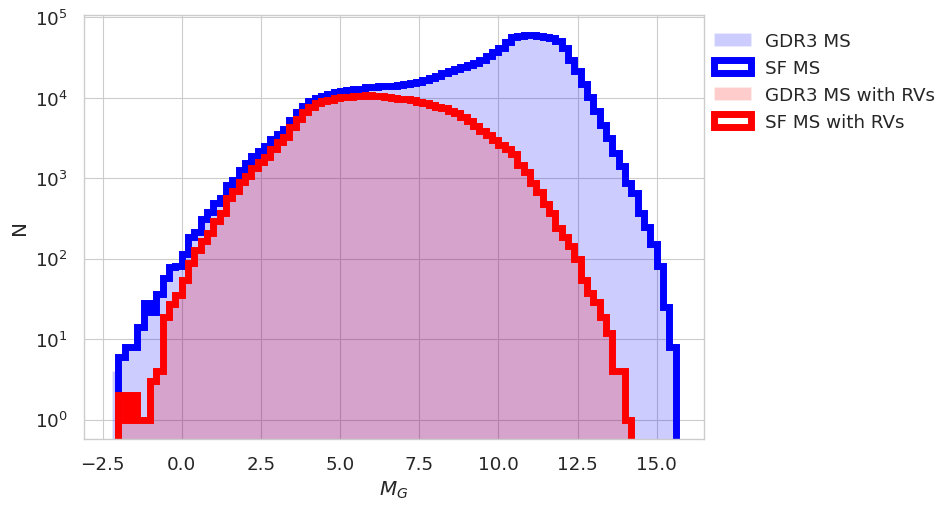

In [5]:
dMGbins         = 0.2
MGbins          = np.arange(gdr3MS.MG.min()-gdr3MS.MG.min()%dMGbins,gdr3MS.MG.max()-gdr3MS.MG.max()%dMGbins+dMGbins,dMGbins)
plt.hist(gdr3MS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS',color='blue',alpha=0.2);
plt.hist(gogFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS',color='blue',linewidth=5);
plt.hist(gdr3RVMS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS with RVs',color='red',alpha=0.2);
plt.hist(gogRVFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS with RVs',color='red',linewidth=5);
plt.xlabel(r'$M_G$')
plt.ylabel(r'N')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.4, 1.))

# Residue function building

In [6]:
gogRVMS = pd.read_csv('builded_or_modified_cat/gog_XYZUVW.csv')

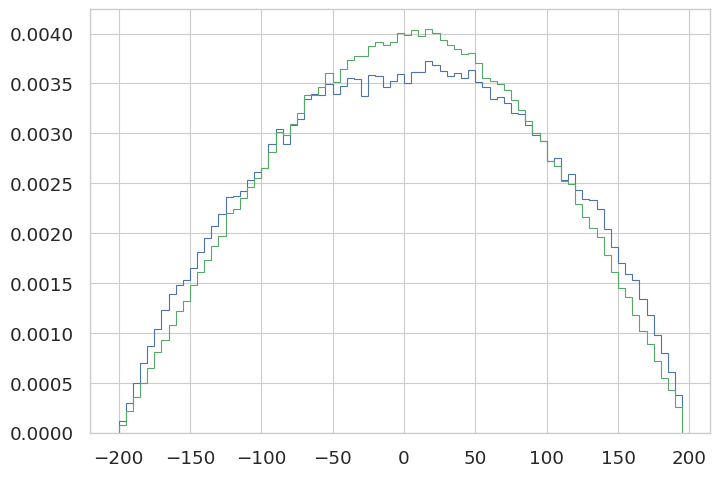

In [7]:
MGbins = np.arange(-200,200,5)
plt.hist(gogRVFinalField.X,histtype='step',bins=MGbins,density=True);
plt.hist(gogRVMS[gogRVMS.radial_velocity_error.isnull().values==False].X,bins=MGbins,histtype='step',density=True);

In [8]:
# Here we define the function used to calculate residues
def residue(data1,data2,deltabins,referencedata,relativeError):
    hist1                   = pd.DataFrame(np.histogram(data1,bins=deltabins)[0])
    hist2                   = pd.DataFrame(np.histogram(data2,bins=deltabins)[0])
    binmids                 = np.histogram(data1,bins=deltabins)[1]
    binmids                 = (binmids[1:]+binmids[:-1])/2
    res                     = hist1-hist2
    
    if relativeError == "yes":
        if referencedata.equals(data1):
            dataref             = hist1
            datanoref           = hist2
            res                 = res/dataref
            reserror            = np.sqrt(1/dataref+datanoref)/dataref
        else:
            dataref             = hist2
            datanoref           = hist1
            res                 = res/dataref
            reserror            = np.sqrt(1/dataref+datanoref)/dataref
    else:
        reserror            = np.sqrt(hist1+hist2)
    
    return res,reserror,binmids

# Kinematic comparison between Gaia DR3 and the synthetic field

## Kinematic residue calculation

In [9]:
# We define bins and other basic objects for the histograms of the kinematic residue
Dbins                   = np.arange(-200,205,5)
Vbins                   = np.arange(-150,155,5)
mubins                  = np.arange(-200,205,5)
resXYZUVW               = []
reserrorXYZUVW          = []
binmidsRV               = []
resXYZmu                = []
reserrorXYZmu           = []
binmidsmu               = []

# We build the histograms for the RV samples
for name in ["X","Y","Z","U","V","W"]:
    if (name == "X") | (name == "Y") | (name == "Z"):
        bins = Dbins
    else:
        bins = Vbins
    res,reserror,mids = residue(gogRVFinalField[name],
                                gdr3RVMS[name],
                                bins,
                                gdr3RVMS[name],
                                "no")
    
    resXYZUVW         += [res]
    reserrorXYZUVW    += [reserror]
    binmidsRV         += [mids]
    
# We build the histograms foe the samples used in the propper  motion space
for name in ["X","Y","Z","pmraLSR","pmdecLSR"]:
    if (name == "X") | (name == "Y") | (name == "Z"):
        bins = Dbins
    else:
        bins = mubins
    res,reserror,mids = residue(gogFinalField[name],
                                gdr3MS[name],
                                bins,
                                gdr3MS[name],
                                "no")
    
    resXYZmu          += [res]
    reserrorXYZmu     += [reserror]
    binmidsmu         += [mids]  

## Kinematic Histogram diagrams

In [ ]:
ax = axs[i,0]



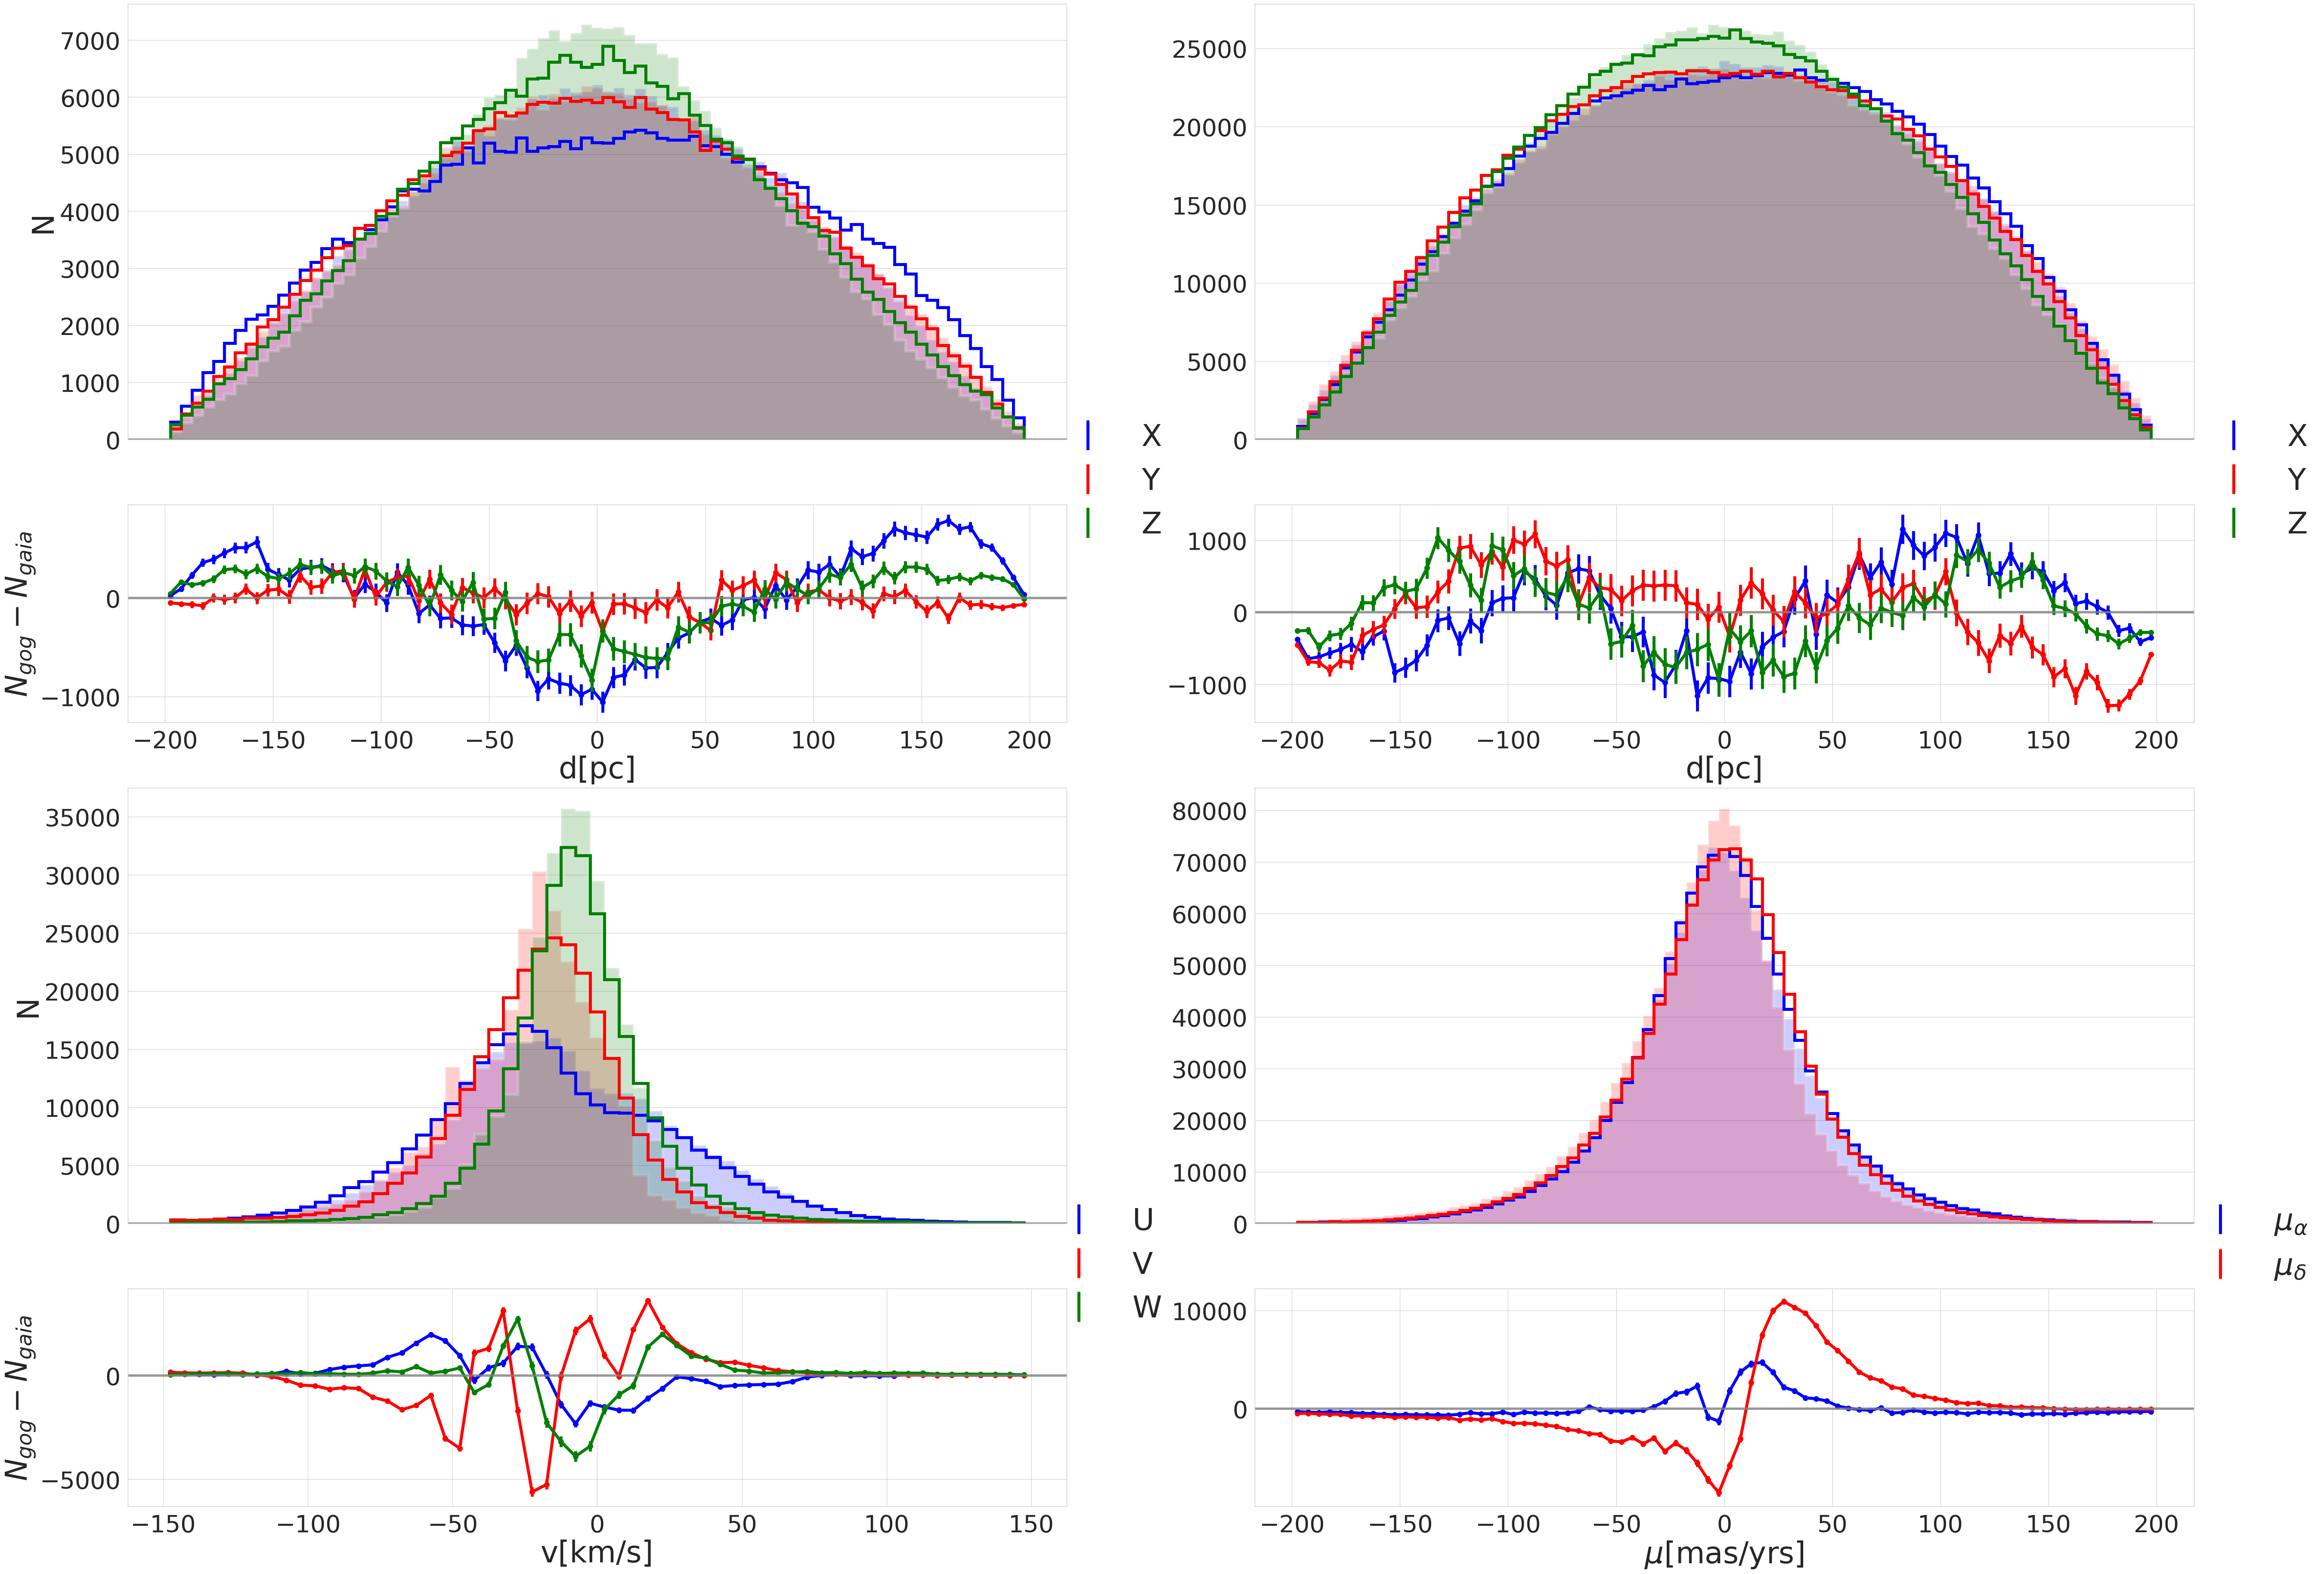

In [10]:
# We define basic objects for the diagrams
labelfontsize   = 50
tickfontsize    = 30
colors          = ["blue","red","green"]
resDlabel       = r'$N_{gog}-N_{gaia}$'
lineWidth       = 5
sWidth          = 300
alphaHistGaia   = 0.2

fig, axs = plt.subplots(4,2,figsize=(16,9), gridspec_kw={'height_ratios': [2,1,2,1]})
fig=plt.figure(1)
fig.subplots_adjust(left=0.1,right=2.5,bottom=0.01,top=3.5,wspace=0.2,hspace=0.2)
fig.set_figheight(10)
fig.set_figwidth(20)

ax = axs[0,0]
for i in [0,1,2]:
    name = ["X","Y","Z"][i]
    ax.hist(gdr3RVMS[name],bins=binmidsRV[i],histtype='stepfilled',linewidth=5,color = colors[i-3],alpha=alphaHistGaia)
    ax.hist(gogRVFinalField[name],bins=binmidsRV[i],histtype='step',linewidth=5,color = colors[i-3])
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_ylabel('N',fontsize=labelfontsize)
ax.set_xticks([])

ax = axs[1,0]
for i in [0,1,2]:
    name = ["X","Y","Z"][i]
    ax.errorbar(binmidsRV[i],
                resXYZUVW[i][0],
                yerr = reserrorXYZUVW[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i])
    ax.plot(binmidsRV[i],
            resXYZUVW[i][0],
            color = colors[i],
            linewidth=lineWidth)
    ax.scatter(binmidsRV[i],
               resXYZUVW[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i])
ax.legend(fontsize = labelfontsize)
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_ylabel(resDlabel,fontsize=labelfontsize)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.13, 1.5))
ax.set_xlabel("d[pc]",fontsize=labelfontsize)







ax = axs[2,0]
for i in [3,4,5]:
    name = ["U","V","W"][i-3]
    ax.hist(gdr3RVMS[name],bins=binmidsRV[i],histtype='stepfilled',linewidth=5,color = colors[i-3],alpha=alphaHistGaia)
    ax.hist(gogRVFinalField[name],bins=binmidsRV[i],histtype='step',linewidth=5,color = colors[i-3])
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_ylabel('N',fontsize=labelfontsize)
ax.set_xticks([])

ax = axs[3,0]
for i in [3,4,5]:
    name = ["U","V","W"][i-3]
    ax.errorbar(binmidsRV[i],
                resXYZUVW[i][0],
                yerr = reserrorXYZUVW[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i-3])
    ax.plot(binmidsRV[i],
            resXYZUVW[i][0],
            color = colors[i-3],
            linewidth=lineWidth)
    ax.scatter(binmidsRV[i],
               resXYZUVW[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i-3])
ax.legend(fontsize = labelfontsize)
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_ylabel(resDlabel,fontsize=labelfontsize)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.13, 1.5))
ax.set_xlabel("v[km/s]",fontsize=labelfontsize)












ax = axs[0,1]
for i in [0,1,2]:
    name = ["X","Y","Z"][i]
    ax.hist(gdr3MS[name],bins=binmidsmu[i],histtype='stepfilled',linewidth=5,color = colors[i-3],alpha=alphaHistGaia)
    ax.hist(gogFinalField[name],bins=binmidsmu[i],histtype='step',linewidth=5,color = colors[i-3])
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xticks([])

ax = axs[1,1]
for i in [0,1,2]:
    name = ["X","Y","Z"][i]
    ax.errorbar(binmidsmu[i],
                resXYZmu[i][0],
                yerr = reserrorXYZmu[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i])
    ax.plot(binmidsmu[i],
            resXYZmu[i][0],
            color = colors[i],
            linewidth=lineWidth)
    ax.scatter(binmidsmu[i],
               resXYZmu[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i])
ax.legend(fontsize = labelfontsize)
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.15, 1.5))
ax.set_xlabel("d[pc]",fontsize=labelfontsize)










ax = axs[2,1]
for i in [3,4]:
    name = [r"$μ_{α}$",r"$μ_{δ}$"][i-3]
    namemu = ['pmraLSR','pmdecLSR'][i-3]
    ax.hist(gdr3MS[namemu],bins=binmidsmu[i],histtype='stepfilled',linewidth=5,color = colors[i-3],alpha=alphaHistGaia)
    ax.hist(gogFinalField[namemu],bins=binmidsmu[i],histtype='step',linewidth=5,color = colors[i-3])
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xticks([])

ax = axs[3,1]
for i in [3,4]:
    name = [r"$μ_{α}$",r"$μ_{δ}$"][i-3]
    namemu = ['pra','pmdec'][i-3]
    ax.errorbar(binmidsmu[i],
                resXYZmu[i][0],
                yerr = reserrorXYZmu[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i-3])
    ax.plot(binmidsmu[i],
            resXYZmu[i][0],
            color = colors[i-3],
            linewidth=lineWidth)
    ax.scatter(binmidsmu[i],
               resXYZmu[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i-3])
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.15, 1.5))
ax.axhline(y=0,color="grey",alpha=0.8,linewidth=4)
ax.tick_params(axis='both', which='both', labelsize=tickfontsize)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.set_xlabel(r"$μ$[mas/yrs]",fontsize=labelfontsize)




fig.savefig("plots_and_images/xyzuvwmu_gog_vs_gaia_0.1.jpg",bbox_inches='tight')

## General photometric and kinematic calculations for GDR3 builded with photo-geometric distances

In [11]:
# Absolute magnitude and color calculation:
MG              = gdr3pg["phot_g_mean_mag"]+5-5*np.log10(gdr3pg["r_hi_photogeo"])
BR              = gdr3pg["phot_bp_mean_mag"]-gdr3pg["phot_rp_mean_mag"]

# We join the new photometric info to the rest of the data:
photo           = pd.concat([MG,BR],axis=1)
photo.columns   = ["MG","BR"]
gdr3pg          = pd.concat([gdr3pg,photo],axis=1)

In [12]:
gdr3pg = gdr3pg[(gdr3pg.BR.isnull().values == False) &
                (gdr3pg.MG.isnull().values == False) &
                (gdr3pg.ruwe < 1.4) &
                (0.039*gdr3pg.BR+0.001 < np.log10(gdr3pg.phot_bp_rp_excess_factor)) &
                (0.039*gdr3pg.BR+0.12 > np.log10(gdr3pg.phot_bp_rp_excess_factor)) &
                (gdr3pg.phot_g_mean_mag <= 18.5)]

## Final GDR3PG sub-samples

In [13]:
# We discard stars below the MS locus
gdr3pgMSPMS = gdr3pg[gdr3pg["MG"] < 3*(gdr3pg["BR"])+3.5]

# We discard post-MS stars and get the MS + PMS
gdr3pgMSPMS = gdr3pgMSPMS[((gdr3pgMSPMS["BR"] > 6/5) & (gdr3pgMSPMS["MG"] > -0.5*(gdr3pgMSPMS["BR"])+4)) |
                          ((gdr3pgMSPMS["BR"] <= 6/5) & (gdr3pgMSPMS["MG"] > 5*(gdr3pgMSPMS["BR"])-3)) |
                          (gdr3pgMSPMS["BR"] < 0.7)]

# With a certain tolerance we discard the PMS to keep only the MS
gdr3pgMS = massPhoto.isochroneSelector(data = gdr3pgMSPMS,
                                       age = 100e6,
                                       deltaMag = [1,1],
                                       dataMagName = 'MG',
                                       dataColorNames = 'BR')

# We define from the previous sub-samples new sub-samples with RVs
gdr3pgRVMSPMS = gdr3pgMSPMS[(gdr3pgMSPMS.radial_velocity.isnull().values == False) & (np.abs(gdr3pgMSPMS.radial_velocity_error/gdr3pgMSPMS.radial_velocity) <= 0.1)]
gdr3pgRVMS    = gdr3pgMS[(gdr3pgMS.radial_velocity.isnull().values == False) & (np.abs(gdr3pgMS.radial_velocity_error/gdr3pgMS.radial_velocity) <= 0.1)]

In [14]:
gdr3pgMSPMS   = gdr3pgMSPMS.set_index(gdr3pgMSPMS.source_id)
gdr3pgRVMSPMS = gdr3pgRVMSPMS.set_index(gdr3pgRVMSPMS.source_id)
gdr3MSPMS     = gdr3MSPMS.set_index(gdr3MSPMS.source_id)
gdr3RVMSPMS   = gdr3RVMSPMS.set_index(gdr3RVMSPMS.source_id)

MSPMSRVmatch  = pd.concat([gdr3RVMSPMS.drop(gdr3RVMSPMS.columns,axis=1),gdr3pgRVMSPMS],axis=1,join='inner')
MSPMSmatch    = pd.concat([gdr3MSPMS.drop(gdr3MSPMS.columns,axis=1),gdr3pgMSPMS],axis=1,join='inner')

In [15]:
(gdr3RVMS.shape[0]-gogRVFinalField.shape[0])/gdr3RVMS.shape[0]

0.0

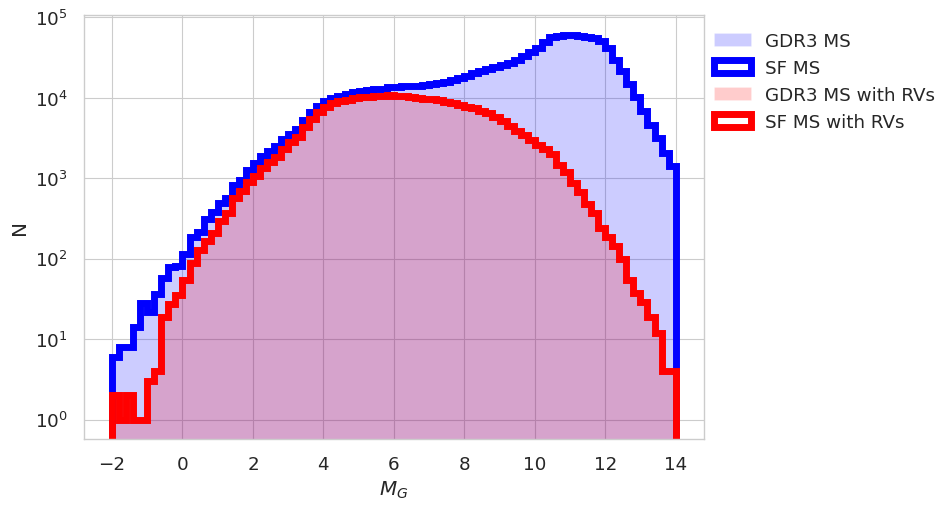

In [16]:
dMGbins         = 0.2
MGbins          = np.arange(gdr3RVMS.MG.min()-gdr3RVMS.MG.min()%dMGbins,gdr3RVMS.MG.max()-gdr3RVMS.MG.max()%dMGbins+dMGbins,dMGbins)
plt.hist(gdr3MS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS',color='blue',alpha=0.2);
plt.hist(gogFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS',color='blue',linewidth=5);
plt.hist(gdr3RVMS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS with RVs',color='red',alpha=0.2);
plt.hist(gogRVFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS with RVs',color='red',linewidth=5);
plt.xlabel(r'$M_G$')
plt.ylabel(r'N')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.4, 1.))

In [17]:
comparer = pd.DataFrame({'gdr3':[gdr3MSPMS.shape[0]],
                         'gdr3RV':[gdr3RVMSPMS.shape[0]],
                         'gdr3pg':[gdr3pgMSPMS.shape[0]],
                         'gdr3pgRV':[gdr3pgRVMSPMS.shape[0]],
                         'MSPMSmatch':[MSPMSmatch.shape[0]],
                         'MSPMSRVmatch':[MSPMSRVmatch.shape[0]]},index=['N'])

In [18]:
MSPMSmatch[1000/MSPMSmatch.parallax < 0.95*MSPMSmatch.r_hi_photogeo-1]

,source_id,ra,dec,parallax,parallax_error,pmra,pmdec,radial_velocity,radial_velocity_error,phot_g_mean_mag,...,source_id.1,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,flag,MG,BR
source_id,,,,,,,,,,,,,,,,,,,,,
2680530286760174592,2680530286760174592,330.295867,-0.127059,10.010847,0.219753,30.652506,-9.122826,NaN,NaN,18.414500,...,2680530286760174592,100.01410,98.043020,101.742500,103.57964,98.194360,106.475130,10022,13.278259,3.538380
5892584324265556992,5892584324265556992,219.033581,-55.914783,10.013560,0.118726,-195.550870,-91.914938,NaN,NaN,17.148842,...,5892584324265556992,99.39778,98.243830,100.530660,99.81791,98.329690,143.713620,10033,11.361352,3.541408
5944339436083979264,5944339436083979264,249.351659,-43.899438,10.015000,0.131521,-0.910341,-90.055619,NaN,NaN,17.913850,...,5944339436083979264,99.50007,98.130570,100.887040,100.29569,98.552600,116.902504,10033,12.574731,3.225729
4110625482939017472,4110625482939017472,262.969475,-23.946900,10.015782,0.156417,-42.950456,-79.036633,NaN,NaN,18.094557,...,4110625482939017472,99.38617,97.740010,101.271090,99.98734,97.747856,153.210820,10033,12.168110,3.924771
4311729733064887808,4311729733064887808,283.472623,10.288470,10.022413,0.105423,-16.966111,-6.695620,NaN,NaN,17.232029,...,4311729733064887808,99.06023,98.169914,99.999985,99.39275,98.331760,112.143860,10033,11.983151,3.299324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6218112466985474176,6218112466985474176,223.309761,-30.040940,5.492612,0.275502,-61.228031,-26.120056,NaN,NaN,18.396275,...,6218112466985474176,180.91554,173.582140,189.682830,183.59180,173.067060,194.326720,10033,11.953612,3.200550
6724169771802243968,6724169771802243968,270.502942,-43.799776,5.492691,0.270342,67.522727,-48.916871,NaN,NaN,18.497220,...,6724169771802243968,184.36957,176.569660,193.684450,189.25139,181.937650,198.321730,10033,12.010368,2.931069
6004714371187601280,6004714371187601280,225.718666,-42.241687,5.495336,0.248284,52.595678,-3.029294,NaN,NaN,18.462849,...,6004714371187601280,182.16609,175.111850,189.230160,185.12670,176.951770,193.582460,10033,12.028519,3.058721


In [19]:
comparer

,gdr3,gdr3RV,gdr3pg,gdr3pgRV,MSPMSmatch,MSPMSRVmatch
N,1372445,313002,1353650,314122,1348303,312450


In [20]:
comparer.gdr3pg-comparer.gdr3

N   -18795
dtype: int64

In [21]:
(comparer.gdr3pg-comparer.gdr3)/comparer.gdr3pg

N   -0.013885
dtype: float64

In [22]:
(gdr3MSPMS.phot_g_mean_flux/gdr3MSPMS.phot_g_mean_flux_error).min()

23.048096848918966

In [23]:
MGbins      = np.arange(4,18.5,0.2)
SNRbins     = np.arange(0,3000,50)
resMG       = []
reserrorMG  = []
midsMG      = []
resSNR      = []
reserrorSNR = []
midsSNR     = []
name        = 'phot_g_mean_mag'

MGPGlist = [gdr3pgMSPMS[name],gdr3pgMS[name],gdr3pgRVMSPMS[name]]
MGlist   = [gdr3MSPMS[name],gdr3MS[name],gdr3RVMSPMS[name]]
SNRlist  = [gdr3MSPMS.phot_g_mean_flux/gdr3MSPMS.phot_g_mean_flux_error,
           gdr3MS.phot_g_mean_flux/gdr3MS.phot_g_mean_flux_error,
           gdr3RVMSPMS.phot_g_mean_flux/gdr3RVMSPMS.phot_g_mean_flux_error]
SNRPGlist  = [gdr3pgMSPMS.phot_g_mean_flux/gdr3pgMSPMS.phot_g_mean_flux_error,
              gdr3pgMS.phot_g_mean_flux/gdr3pgMS.phot_g_mean_flux_error,
              gdr3pgRVMSPMS.phot_g_mean_flux/gdr3pgRVMSPMS.phot_g_mean_flux_error]

for i in np.arange(0,len(MGlist),1):
    res,reserror,mids = residue(MGlist[i],
                                MGPGlist[i],
                                MGbins,
                                MGPGlist[i],
                                "no")
    resMG      += [res]
    reserrorMG += [reserror]
    midsMG     += [mids]
    
for i in np.arange(0,len(MGlist),1):
    res,reserror,mids = residue(SNRlist[i],
                                SNRPGlist[i],
                                SNRbins,
                                MGPGlist[i],
                                "no")
    resSNR      += [res]
    reserrorSNR += [reserror]
    midsSNR     += [mids]

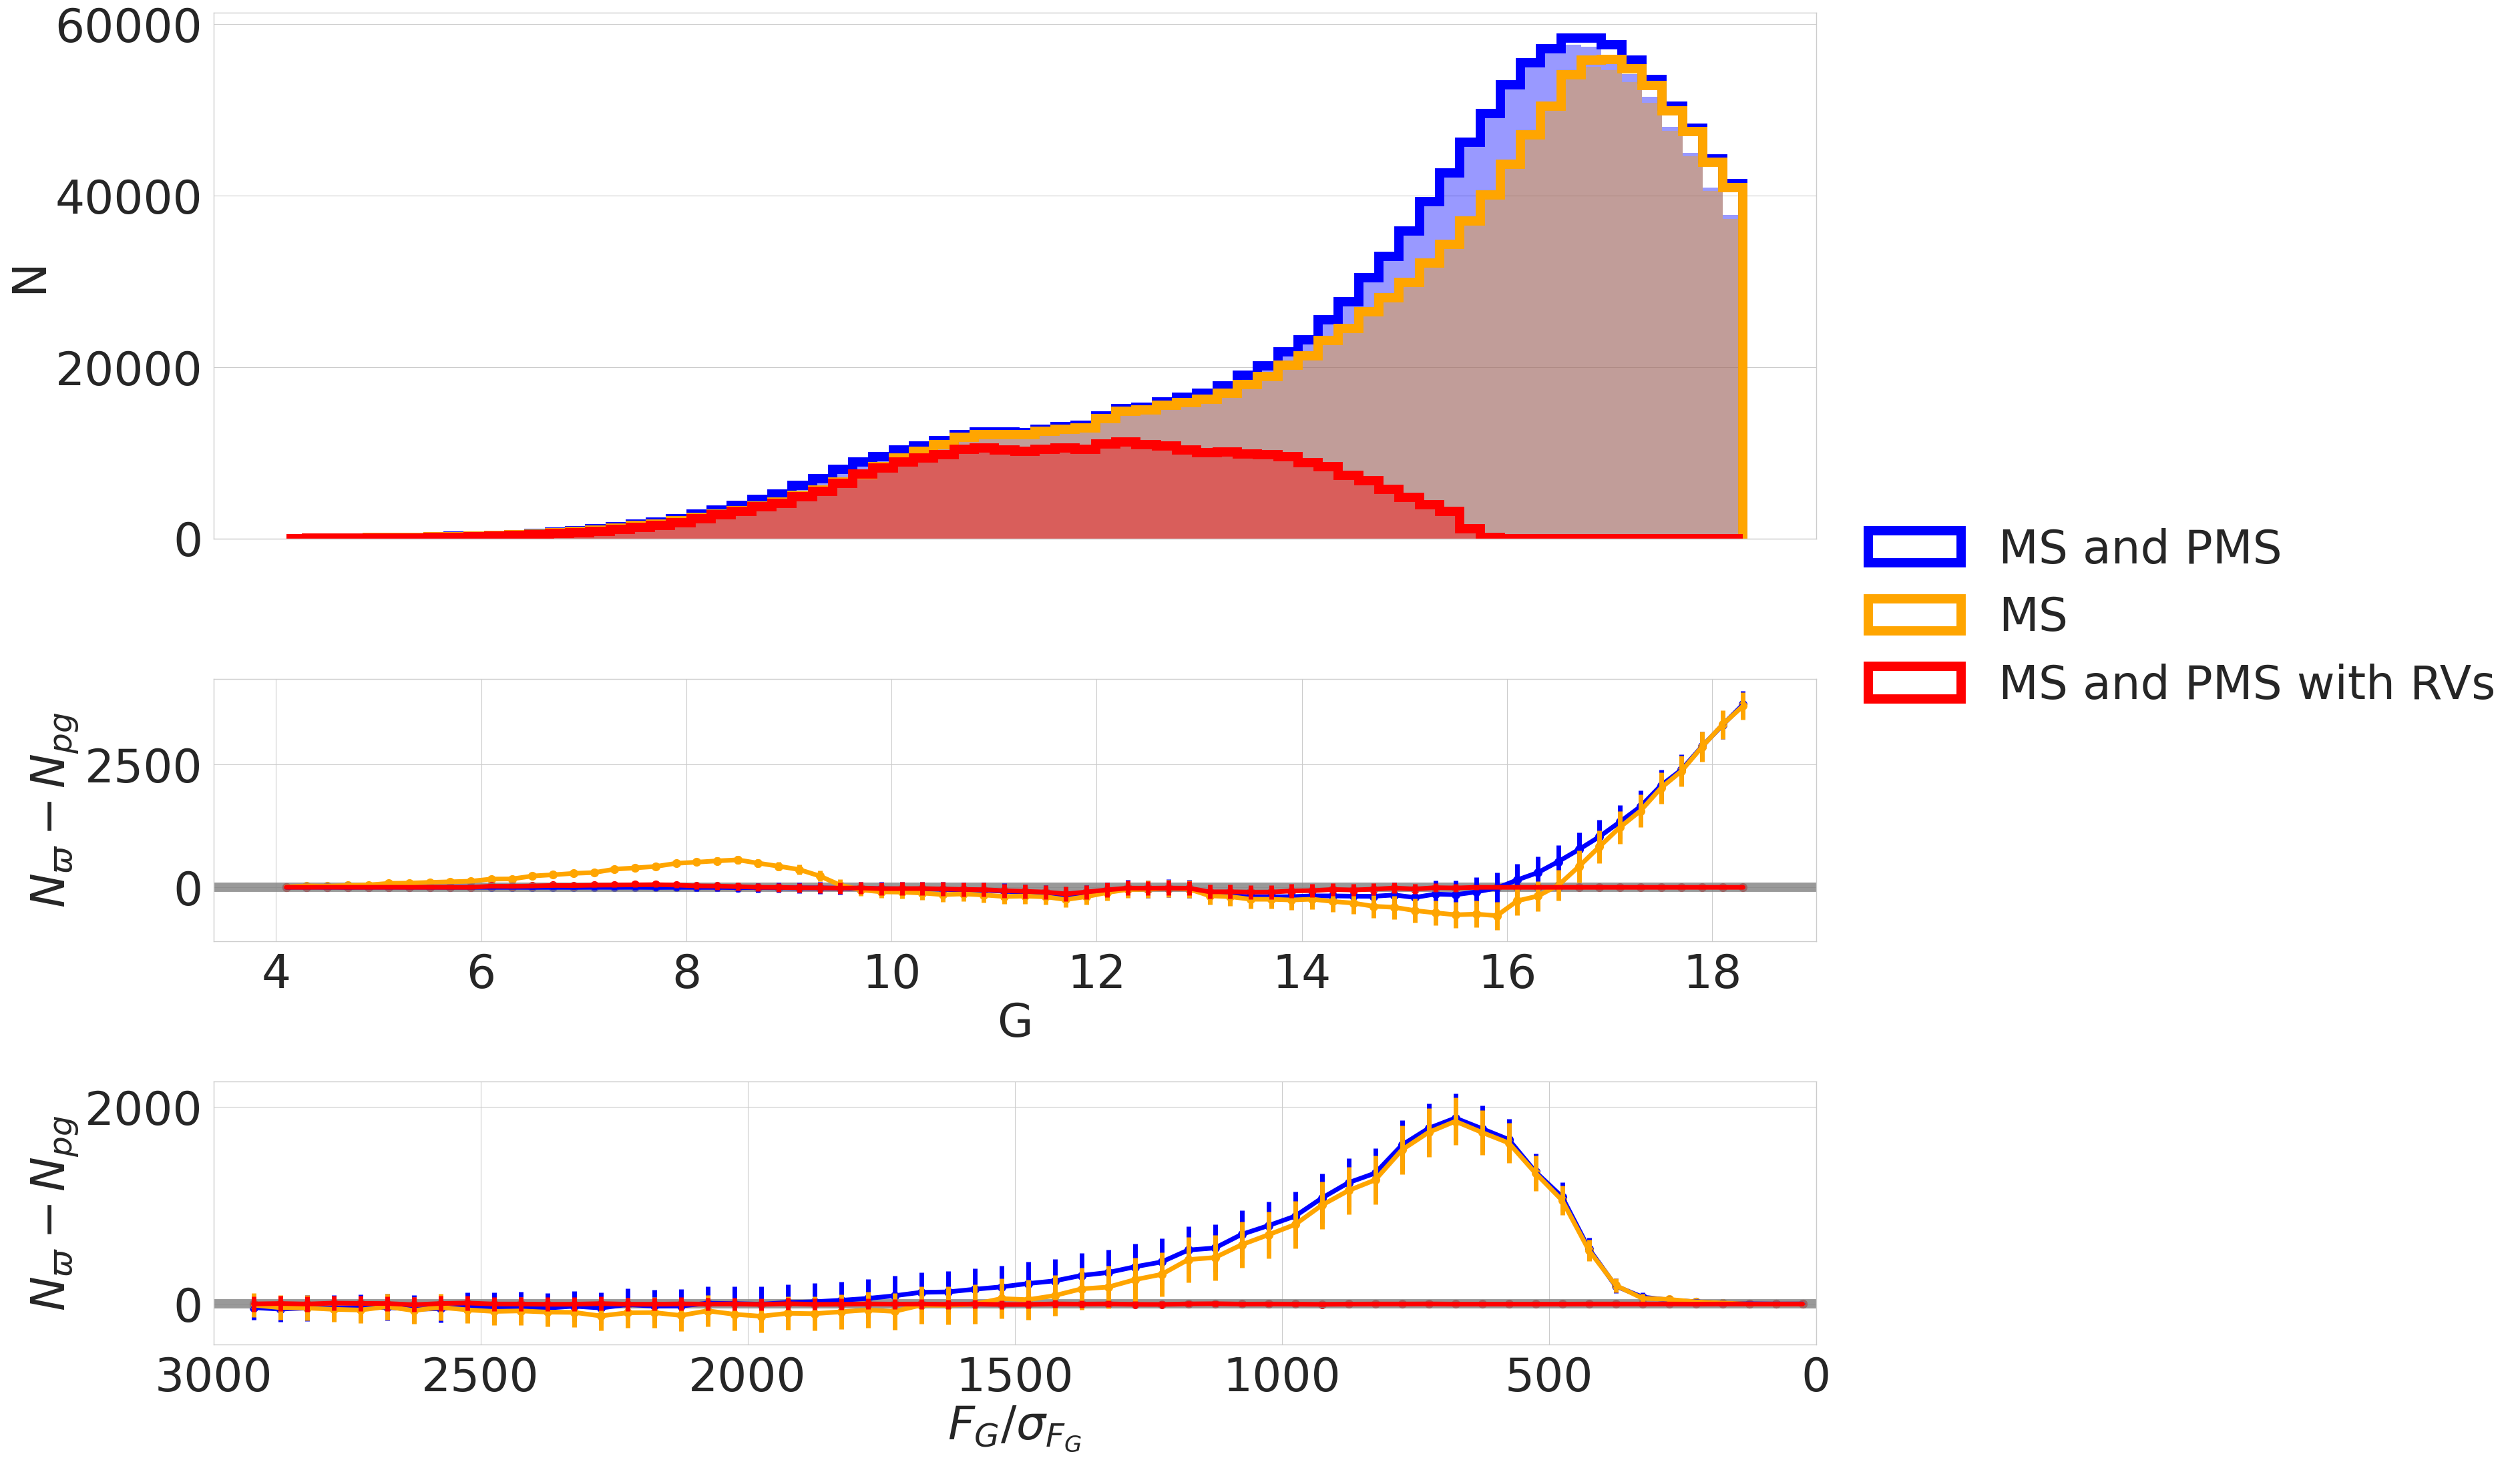

In [24]:
logScale  = False
colors    = ['blue','orange','red']
legLabels = ['MS and PMS','MS', 'MS and PMS with RVs']

fig, axs = plt.subplots(3,1,figsize=(16,9), gridspec_kw={'height_ratios': [2,1,1]})
fig=plt.figure(1)
fig.subplots_adjust(left=0.1,right=2.5,bottom=0.01,top=4,wspace=0.2,hspace=0.4)
fig.set_figheight(5)
fig.set_figwidth(10)

ax = axs[0]
for i in np.arange(0,len(MGlist),1):

    ax.hist(MGPGlist[i],bins=MGbins,log=logScale,histtype='stepfilled',color=colors[i],linewidth=0,alpha=0.4);
    ax.hist(MGlist[i],bins=MGbins,log=logScale,histtype='step',color=colors[i],linewidth=10,label=legLabels[i]);
ax.tick_params(axis='both', which='both', labelsize=50)
ax.set_ylabel('N',fontsize=50)
ax.legend(loc=1, bbox_to_anchor=(1.45,0.1),fontsize = 50)

ax.set_xticks([])
ax = axs[1]

ax.axhline(y=0,color="grey",alpha=0.8,linewidth=10)
for i in np.arange(0,len(MGlist),1):
    ax.errorbar(midsMG[i],
                resMG[i][0],
                yerr = reserrorMG[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i])
    ax.plot(midsMG[i],
            resMG[i][0],
            color = colors[i],
            linewidth=lineWidth)
    ax.scatter(midsMG[i],
               resMG[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i])
ax.tick_params(axis='both', which='both', labelsize=50)
ax.set_xlabel("G",fontsize=50)
ax.set_ylabel(r"$N_{\varpi}-N_{pg}$",fontsize=50)

ax = axs[2]

ax.axhline(y=0,color="grey",alpha=0.8,linewidth=10)
for i in np.arange(0,len(MGlist),1):
    ax.errorbar(midsSNR[i],
                resSNR[i][0],
                yerr = reserrorSNR[i][0],
                marker = ".",
                markersize=0,
                ls='none',
                label=name,
                elinewidth=lineWidth,
                color = colors[i])
    ax.plot(midsSNR[i],
            resSNR[i][0],
            color = colors[i],
            linewidth=lineWidth)
    ax.scatter(midsSNR[i],
               resSNR[i][0],
               marker = ".",
               s=sWidth,
               color = colors[i])
ax.tick_params(axis='both', which='both', labelsize=50)
ax.set_xlabel(r"$F_G/\sigma_{F_G}$",fontsize=50)
ax.set_ylabel(r"$N_{\varpi}-N_{pg}$",fontsize=50)
ax.set_xlim(3000,0)

fig.savefig("plots_and_images/photogeo_vs_parallax_0.1.jpg",bbox_inches='tight')




# Kinematic errors analysis

In [25]:
# This function build the discrete relationship between xName and yName from data by calculating the mean and std by dx bins 
def meanStdInterpolator(data,xName,yName,dx,allx,meanName,stdName):
    discrete = pd.DataFrame(columns=[xName,meanName,stdName])
    for i in np.arange(0,len(allx)-1,1):
        xmin        = round(allx[i]-dx,3)
        xmax        = round(allx[i]+dx,3)
        mean        = pd.DataFrame([data[(data[xName] >= xmin) & (data[xName] < xmax)][yName].mean()])
        std         = pd.DataFrame([data[(data[xName] >= xmin) & (data[xName] < xmax)][yName].std()])
        row         = pd.concat([pd.DataFrame([allx[i]]),mean,std],axis=1)
        row.columns = discrete.columns
        discrete    = pd.concat([discrete,row],axis=0).reset_index(drop=True)
        
    return discrete

In [26]:
# We define the required objects to interpolate the kinematical errors
XNAME             = 'phot_g_mean_mag'
Nbins             = 100
Xbins             = np.arange(gdr3MSPMS[XNAME].min(),gdr3MSPMS[XNAME].max(),(gdr3MSPMS[XNAME].max()-gdr3MSPMS[XNAME].min())/Nbins)
dX                = (gdr3MSPMS[XNAME].max()-gdr3MSPMS[XNAME].min())/Nbins
errorsNames       = ['X_error','Y_error','Z_error','U_error','V_error','W_error','pmraLSR_error','pmdecLSR_error',XNAME]
rvpmDiscreteErros = {}
rvpmAnalyticErros = {}

# We compute the errors
for i in np.arange(0,len(errorsNames),1):
    name           = errorsNames[i]
    discreteErrors = meanStdInterpolator(data     = gdr3MSPMS,
                                         xName    = XNAME,
                                         yName    = name,
                                         dx       = dX,
                                         allx     = Xbins,
                                         meanName = name+'_mean',
                                         stdName  = name+'_std')
    analyticErrrors = {name+'_mean':interpolate.interp1d(discreteErrors[XNAME],discreteErrors[name+'_mean'],kind='linear'),
                       name+'_std':interpolate.interp1d(discreteErrors[XNAME],discreteErrors[name+'_std'],kind='linear')}
    rvpmDiscreteErros.update({name:discreteErrors})
    rvpmAnalyticErros.update(analyticErrrors)

rvpmAnalyticErros.update({XNAME:discreteErrors[XNAME]})
rvpmDiscreteErros.update({XNAME:discreteErrors[XNAME]})

KeyError: 'pmraLSR_error'

In [ ]:
# Graphic of errors
labelfontsize = 30
dotsize       = 100
linesize      = 5
colors        = ["blue","red","green"]

fig, axs = plt.subplots(3,1,figsize=(16,9))
fig=plt.figure(1)
fig.subplots_adjust(left=0.1,right=2.5,bottom=0.01,top=4,wspace=0.2,hspace=0.4)
fig.set_figheight(5)
fig.set_figwidth(10)

ax = axs[0]
    
for i in np.arange(0,3,1):
    labelNames = ['X','Y','Z']
    labelName = labelNames[i]
    name = errorsNames[i]
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],linewidth=linesize,color=colors[i-3])
    ax.scatter(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],label=labelName,s=dotsize,color=colors[i-3])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']-rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-3])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']+rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-3])

ax.set_xlim(rvpmDiscreteErros[name][XNAME].min()-0.2,rvpmDiscreteErros[name][XNAME].max()+0.2)
ax.tick_params(axis='x', labelsize=0)
ax.tick_params(axis='y', labelsize=labelfontsize)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.1, 0.5))
ax.set_ylabel(r'$\Delta$D [pc]',fontsize=labelfontsize)
    
ax = axs[1]
    
for i in np.arange(3,6,1):
    labelNames = ['U','V','W']
    labelName = labelNames[i-3]
    name = errorsNames[i]
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],linewidth=linesize,color=colors[i-3])
    ax.scatter(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],label=labelName,s=dotsize,color=colors[i-3])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']-rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-3])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']+rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-3])

ax.set_xlim(rvpmDiscreteErros[name][XNAME].min()-0.2,rvpmDiscreteErros[name][XNAME].max()+0.2)
ax.tick_params(axis='x', labelsize=0)
ax.tick_params(axis='y', labelsize=labelfontsize)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.1, 0.5))
ax.set_ylabel(r'$\Delta$V [km/s]',fontsize=labelfontsize)
    
ax = axs[2]
    
for i in np.arange(6,8,1):
    labelNames = [r"$μ_{α}$",r"$μ_{δ}$"]
    labelName = labelNames[i-6]
    name = errorsNames[i]
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],linewidth=linesize,color=colors[i-6])
    ax.scatter(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean'],label=labelName,s=dotsize,color=colors[i-6])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']-rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-6])
    ax.plot(rvpmDiscreteErros[XNAME],rvpmDiscreteErros[name][name+'_mean']+rvpmDiscreteErros[name][name+'_std'],linewidth=linesize*0.5,color=colors[i-6])

ax.set_xlim(rvpmDiscreteErros[name][XNAME].min()-0.2,rvpmDiscreteErros[name][XNAME].max()+0.2)
ax.legend(fontsize = labelfontsize,bbox_to_anchor=(0.0, 0.0, 1.1, 0.5))
ax.set_xlabel(r'$G$',fontsize=labelfontsize)
ax.set_ylabel(r'$\Delta\mu$ [mas/yr]',fontsize=labelfontsize)
ax.tick_params(axis='x', labelsize=labelfontsize)
ax.tick_params(axis='y', labelsize=labelfontsize)
fig.savefig("plots_and_images/kinematic_errors_vs_G_0.1.jpg",bbox_inches='tight')

In [ ]:
# Kinematic error data builded based on GDR3 kinematic error
with open('builded_or_modified_cat/rvpmDiscreteErrors.pickle', 'wb') as handle:
    pickle.dump(rvpmDiscreteErros, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analytical Kinematic error as a function of G builded based on GDR3 kinematic error
with open('builded_or_modified_cat/rvpmAnalyticErrors.pickle', 'wb') as handle:
    pickle.dump(rvpmAnalyticErros, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# All data propagated errors
gdr3MSPMS[['phot_g_mean_mag','X_error','Y_error','Z_error','U_error','V_error','W_error','pmraLSR_error','pmdecLSR_error']].to_csv('builded_or_modified_cat/allKinematicErrors.csv',index=False)